In [91]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import load_iris
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import check_X_y
from sklearn.utils.validation import check_array

warnings.filterwarnings('ignore') 

In [92]:
class DecisionTreeNode:
    def __init__(self):
        self.left_node = None
        self.right_node = None
        self.depth = None
        self.column_id = None
        self.threshold = None
        self.probability = None
        self.depth = None
        self.is_leaf = False

# обертка над результатом split
class DecisionSplit:
    def __init__(self, column_id=None, threshold=None, x_left=None, x_right=None, y_left=None, y_right=None):
        self.x_left = x_left
        self.x_right = x_right
        self.y_left = y_left
        self.y_right = y_right
        self.column_id = column_id
        self.threshold = threshold

class CustomDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=3, min_leaf_count=1, min_split=2):
        self.Root = None
        self.max_depth = max_depth
        self.min_leaf_count = min_leaf_count
        self.min_split = min_split

    def get_params(self, deep=True):
        return {"max_depth": self.max_depth, "min_leaf_count": self.min_leaf_count, "min_split": self.min_split}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, y):
        self.Root = DecisionTreeNode()
        self.Root.depth = 1
        # разбиваем на классы
        self.classes = np.unique(y)
        self.Root.probability = self._calculate_probability(y)
        self._build_tree(X, y, self.Root)

    def _calculate_probability(self, y):
        probabilities = []
        for item in self.classes:
            probability = y[y == item].shape[0] / y.shape[0]
            probabilities.append(probability)
        return np.asarray(probabilities)

    def _build_tree(self, X, y, node: DecisionTreeNode):
        # достигли листового уровня
        if X.shape[0] < self.min_split or node.depth >= self.max_depth or np.unique(y).shape[0] == 1:
            node.is_leaf = True
            return

        split = self._find_best_split(X, y)

        if split.column_id is None or split.x_left.shape[0] < self.min_leaf_count or split.x_right.shape[0] < self.min_leaf_count:
            node.is_leaf = True
            return

        node.left_node = DecisionTreeNode()
        node.left_node.depth = node.depth + 1
        node.left_node.probability = self._calculate_probability(split.y_left)

        node.right_node = DecisionTreeNode()
        node.right_node.depth = node.depth + 1
        node.right_node.probability = self._calculate_probability(split.y_right)

        node.column_id = split.column_id
        node.threshold = split.threshold

        self._build_tree(split.x_left, split.y_left, node.left_node)
        self._build_tree(split.x_right, split.y_right, node.right_node)


    def _find_best_split(self, X, y):
        def calculate_gini_criterion(probabilities):
            return 1 - np.sum(probabilities ** 2)

        best_column_id = None
        best_threshold = None
        best_info_gain = -1

        start_gini = calculate_gini_criterion(self._calculate_probability(y))

        for col in range(X.shape[1]):
            x_col = X[:, col]
            for x_i in x_col:
                threshold = x_i
                y_right = y[x_col > threshold]
                y_left = y[x_col <= threshold]

                if y_right.shape[0] == 0 or y_left.shape[0] == 0:
                    continue

                left_node_gini = calculate_gini_criterion(self._calculate_probability(y_left))
                right_node_gini = calculate_gini_criterion(self._calculate_probability(y_right))

                current_info_gain = start_gini - ((left_node_gini * y_left.shape[0] / y.shape[0]) + (
                            right_node_gini * y_right.shape[0] / y.shape[0]))

                if current_info_gain > best_info_gain:
                    best_column_id = col
                    best_threshold = threshold
                    best_info_gain = current_info_gain

        if best_info_gain == -1:
            return DecisionSplit()

        x_col = X[:, best_column_id]
        x_left, x_right = X[x_col <= best_threshold, :], X[x_col > best_threshold, :]
        y_left, y_right = y[x_col <= best_threshold], y[x_col > best_threshold]

        return DecisionSplit(best_column_id, best_threshold, x_left, x_right, y_left, y_right)

    def predict(self, X):
        predictions = []
        for x in X:
            pred = np.argmax(self._predict_for_node(x, self.Root))
            predictions.append(pred)
            #np.append(predictions, pred)
        return np.asarray(predictions)

    def _predict_for_node(self, x, node: DecisionTreeNode):
        if node.is_leaf:
            return node.probability

        return self._predict_for_node(x, node.right_node) if x[node.column_id] > node.threshold \
            else self._predict_for_node(x, node.left_node)

In [93]:
class CustomSVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.001, lambda_value=0.1):
        self.learning_rate = learning_rate
        self.lambda_value = lambda_value

    def get_params(self, deep=True):
        return {"learning_rate": self.learning_rate, "lambda_value": self.lambda_value}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        n = X.shape[1]
        self.W = np.zeros(n)
        self.b = 0
        self._fit(X, y, n)
        return self

    def _fit(self, X, y, n):
        W = np.zeros(n)
        b = 0
        y_label = np.where(y <= 0, -1, 1)
        for index, x_i in enumerate(X):
            W_delta, b_delta = self.__calculate_deltas(x_i, y_label[index], W, b)
            W = W - self.learning_rate * W_delta
            b = b - self.learning_rate * b_delta

        self.W = W
        self.b = b

    def __calculate_deltas(self, x_i, y_label_i, W, b):
        if y_label_i * (np.dot(x_i, W) - b) >= 1:
            return 2 * self.lambda_value * W, 0
        else:
            return 2 * self.lambda_value * W - np.dot(x_i, y_label_i), y_label_i

    def predict(self, X):
        X = check_array(X)
        result = np.dot(X, self.W) - self.b
        predicted_labels = np.sign(result)
        return np.where(predicted_labels <= -1, 0, 1)


## Датасет

## Описание:

- age - количество лет
- sex - пол (1 = мужской, 0 = женский)
- cp - тип боли в груди
- trestbps - артериальное давление в покое (в мм рт.ст. при поступлении в стационар)
- chol - уровень холестерина в мг/дл
- fbs - (уровень сахара в крови натощак > 120 мг/дл) (1 = верно; 0 = неверно)
- restecg - результаты электрокардиографии в покое
- thalach - достигнута максимальная частота сердечных сокращений
- exang - стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет)
- oldpeak - депрессия ST, вызванная физической нагрузкой, по сравнению с состоянием покоя
- slope - наклон пикового сегмента ST при нагрузке
- ca - количество крупных сосудов (0-3), окрашенных при флюороскопии
- thal - 3 = нормальный; 6 = фиксированный дефект; 7 = обратимый дефект
- target - есть заболевание или нет (1=да, 0=нет)

Будем решать задачу классификации и предсказывать целевой признак **target**: есть ли у пациента заболевание сердца.

In [94]:
df = pd.read_csv('/kaggle/input/input/heart1.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## EDA

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Видно, что пропущенных значений нет, поэтому дополнительной обработки для этого не требуется.

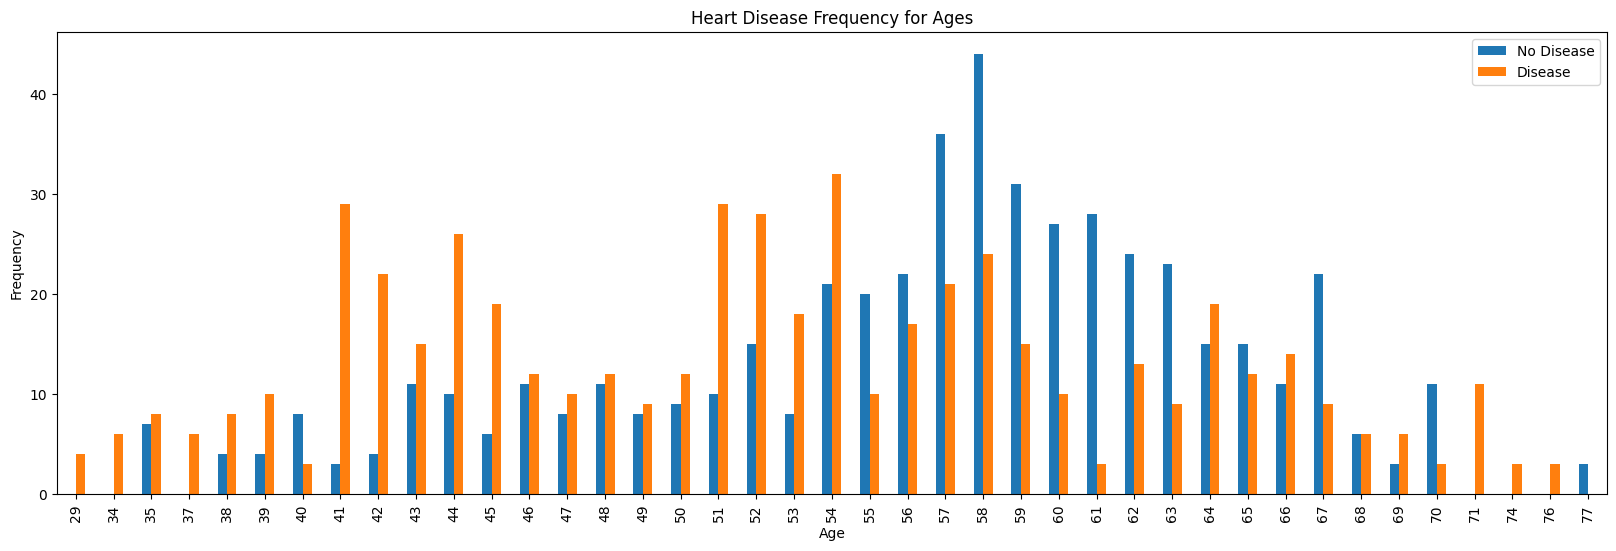

In [96]:
pd.crosstab(df.age,df.target).plot(kind="bar",figsize=(20,6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(["No Disease", "Disease"])
plt.show()

По графику видно, что преимущественно люди в возрасте от 41 до 45 и 51 до 63 переживают сердечный приступ. В то время как в более молодом возрасте от 29 до 40 люди меньше подвержены риску приступа.

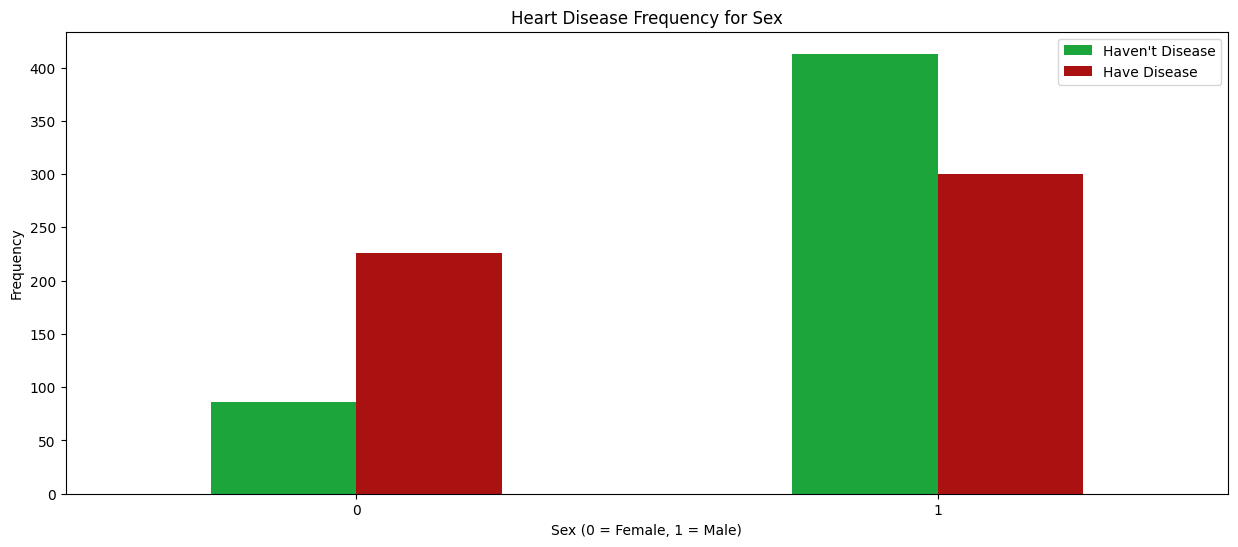

In [97]:
pd.crosstab(df.sex,df.target).plot(kind="bar", figsize=(15, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

По данному графику видно, что чаще сердечному приступу подвержены мужчины. При этом женщин, перенесших приступ больше, чем женщин, у которых приступа не было.

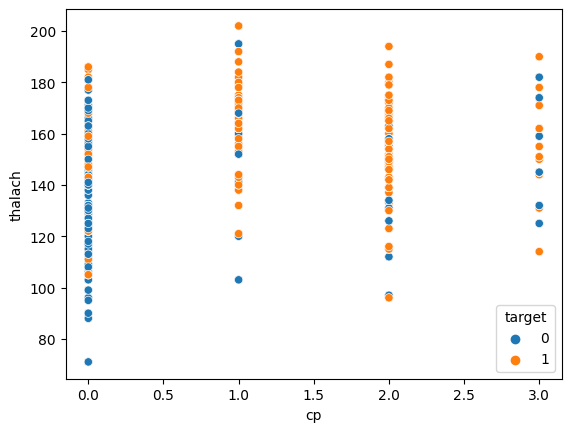

In [98]:
ax = sns.scatterplot(x='cp', y='thalach', hue='target', data=df)

Видно, что у людей с повышенной частотой сердечных сокращений приступ случался чаще. При этом у людей, имеющих тип боли в груди 0 сердечный приступ случался реже, чем у людей с типом боли 1 или 2. Более того, большинство людей с типом боли в груди 1 или 2 перенесли приступ, что может говорить о важности данных признаков **cp** и **thalach** для дальнейшего анализа.

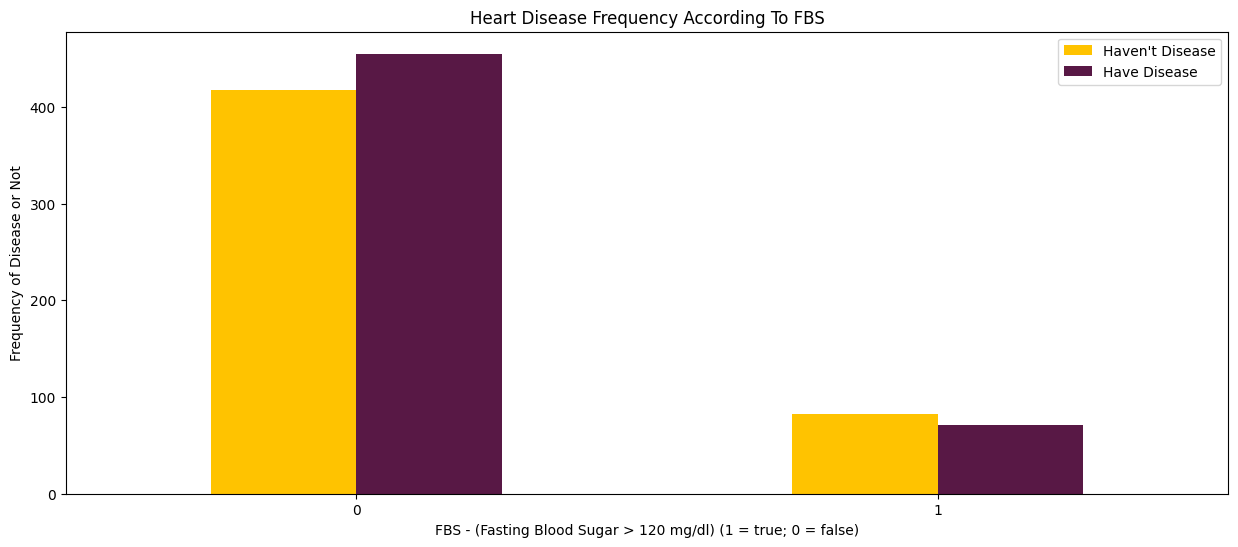

In [99]:
pd.crosstab(df.fbs,df.target).plot(kind="bar", figsize=(15, 6), color=['#FFC300','#581845' ])
plt.title('Heart Disease Frequency According To FBS')
plt.xlabel('FBS - (Fasting Blood Sugar > 120 mg/dl) (1 = true; 0 = false)')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

По данному графику можно сделать вывод, что у людей, перенесших сердечный приступ, был пониженный сахар в крови.
Построим диаграмму корреляции признаков.

<Axes: >

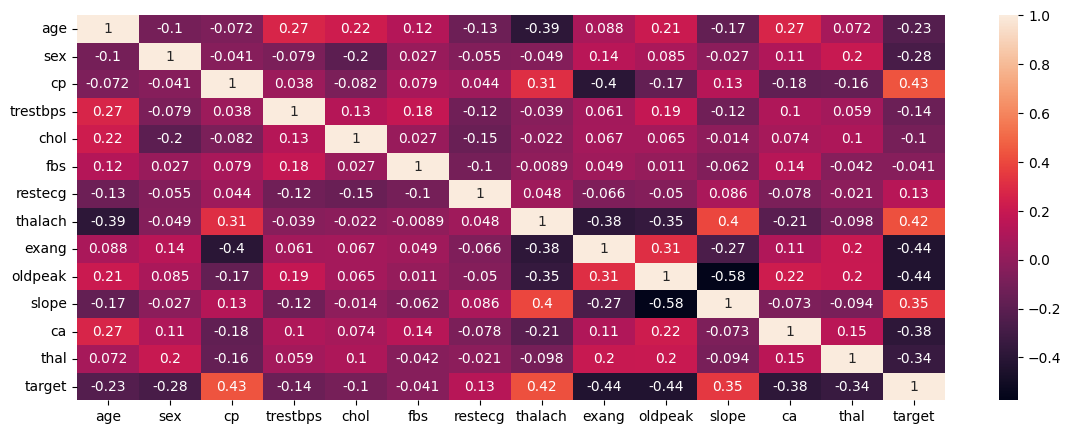

In [100]:
plt.figure(figsize = (14,5))
sns.heatmap(df.corr(),annot=True)

Как видно по построенной таблице, с целевым признаком **target** наибольшую корреляцию имеют признаки **cp**, **thalach** и **slope**, что соответствует и ранее построенным графикам.

## Преобразования данных

Сделаем трансформацию категориальных признаков **cp**, **slope**, **thal** в "фиктивные переменные", представляющие собой числовые переменные для представления категориальных данных:

In [101]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
frames = [df, cp_dum, slope_dum, thal_dum]
df = pd.concat(frames, axis = 1)
df = df.drop(columns = ['cp', 'slope', 'thal'])
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,52,1,125,212,0,1,168,0,1.0,2,...,False,False,False,False,False,True,False,False,False,True
1,53,1,140,203,1,0,155,1,3.1,0,...,False,False,False,True,False,False,False,False,False,True
2,70,1,145,174,0,1,125,1,2.6,0,...,False,False,False,True,False,False,False,False,False,True
3,61,1,148,203,0,1,161,0,0.0,1,...,False,False,False,False,False,True,False,False,False,True
4,62,0,138,294,1,1,106,0,1.9,3,...,False,False,False,False,True,False,False,False,True,False


## Разбиение данных на обучающую и тестовую выборки

In [102]:
x = df.drop(['target'], axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=50)

Используем также масштабирование данных

In [103]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Recursive Feature Elimination (RFE)

Подберем наилучшее количество признаков и оставим только их.

In [104]:
rfecv = RFECV(estimator=LogisticRegression(), cv=5)
rfecv.fit(x_train_scaled, y_train)

selected_features = list(x_train.columns[rfecv.support_])

print(f"Оптимальное число признаков: {rfecv.n_features_}")
print(f'Выбранные признаки: {selected_features}')

Оптимальное число признаков: 14
Выбранные признаки: ['sex', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_0', 'cp_2', 'slope_2', 'thal_1', 'thal_2', 'thal_3']


Уберем лишние признаки:

In [105]:
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x.columns)
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x.columns)
selected_features = list(x_train_scaled_df.columns[rfecv.support_])
x_train_scaled = x_train_scaled_df[selected_features].to_numpy()
x_test_scaled = x_test_scaled_df[selected_features].to_numpy()

## Подбор гиперпараметров модели

Подберем оптимальные гиперпараметры для двух собственных алгоритмов, а также для библиотечных и будем их использовать в дальнейшем при обучении моделей.

## CustomDecisionTree

In [106]:
max_depth_grid = [2, 3, 5]
min_leaf_count_grid = [1, 2, 4]
min_split_grid = [1, 3, 5, 10]
custom_dtc_searcher = GridSearchCV(CustomDecisionTreeClassifier(),
                        [{"max_depth": max_depth_grid, "min_leaf_count": min_leaf_count_grid, "min_split": min_split_grid}],
                        cv=5, verbose=5)
custom_dtc_searcher.fit(x_train_scaled, y_train)

print("Best estimator: " + str(custom_dtc_searcher.best_estimator_))
print("Best params: " + str(custom_dtc_searcher.best_params_))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END max_depth=2, min_leaf_count=1, min_split=1;, score=0.757 total time=   6.9s
[CV 2/5] END max_depth=2, min_leaf_count=1, min_split=1;, score=0.743 total time=   6.8s
[CV 3/5] END max_depth=2, min_leaf_count=1, min_split=1;, score=0.748 total time=   6.8s
[CV 4/5] END max_depth=2, min_leaf_count=1, min_split=1;, score=0.762 total time=   7.2s
[CV 5/5] END max_depth=2, min_leaf_count=1, min_split=1;, score=0.720 total time=   6.8s
[CV 1/5] END max_depth=2, min_leaf_count=1, min_split=3;, score=0.757 total time=   6.9s
[CV 2/5] END max_depth=2, min_leaf_count=1, min_split=3;, score=0.743 total time=   6.9s
[CV 3/5] END max_depth=2, min_leaf_count=1, min_split=3;, score=0.748 total time=   7.1s
[CV 4/5] END max_depth=2, min_leaf_count=1, min_split=3;, score=0.762 total time=   6.8s
[CV 5/5] END max_depth=2, min_leaf_count=1, min_split=3;, score=0.720 total time=   6.9s
[CV 1/5] END max_depth=2, min_leaf_count=1, min_

## CustomSVM

In [107]:
learning_rate_grid = [0.1, 0.01, 0.001, 0.0001]
lambda_value_grid = [0.01, 0.1, 1]

custom_svm_searcher = GridSearchCV(CustomSVMClassifier(),
                                   [{"learning_rate": learning_rate_grid, "lambda_value": lambda_value_grid}],
                                   cv=5, verbose=5)
custom_svm_searcher.fit(x_train_scaled, y_train)

print("Best estimator: " + str(custom_svm_searcher.best_estimator_))
print("Best params: " + str(custom_svm_searcher.best_params_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END lambda_value=0.01, learning_rate=0.1;, score=0.819 total time=   0.0s
[CV 2/5] END lambda_value=0.01, learning_rate=0.1;, score=0.847 total time=   0.0s
[CV 3/5] END lambda_value=0.01, learning_rate=0.1;, score=0.832 total time=   0.0s
[CV 4/5] END lambda_value=0.01, learning_rate=0.1;, score=0.846 total time=   0.0s
[CV 5/5] END lambda_value=0.01, learning_rate=0.1;, score=0.818 total time=   0.0s
[CV 1/5] END lambda_value=0.01, learning_rate=0.01;, score=0.833 total time=   0.0s
[CV 2/5] END lambda_value=0.01, learning_rate=0.01;, score=0.868 total time=   0.0s
[CV 3/5] END lambda_value=0.01, learning_rate=0.01;, score=0.860 total time=   0.0s
[CV 4/5] END lambda_value=0.01, learning_rate=0.01;, score=0.860 total time=   0.0s
[CV 5/5] END lambda_value=0.01, learning_rate=0.01;, score=0.867 total time=   0.0s
[CV 1/5] END lambda_value=0.01, learning_rate=0.001;, score=0.826 total time=   0.0s
[CV 2/5] END lambda

## Sklearn Logistic Regression

In [108]:
param_grid = {'C': np.arange(1e-05, 5, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}
log_reg_searcher = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=5, refit='Accuracy')
log_reg_searcher.fit(x_train_scaled, y_train)
print("Best estimator: " + str(log_reg_searcher.best_estimator_))
print("Best params: " + str(log_reg_searcher.best_params_))

Best estimator: LogisticRegression(C=0.10001)
Best params: {'C': 0.10001}


## Sklearn SVM

In [109]:
C = [0.1, 0.2, 0.5, 1, 2, 5]
kernel = ["linear", "poly", "rbf"]
gamma = [0.001, 0.01, 0.1, 1, "scale", "auto"]

svc_searcher = GridSearchCV(estimator=SVC(random_state=50), cv=5,
                        param_grid=dict(kernel=kernel,C=C, gamma=gamma))
svc_searcher.fit(x_train_scaled, y_train)
print("Best estimator: ", str(svc_searcher.best_estimator_))
print("Best params: ", str(svc_searcher.best_params_))

Best estimator:  SVC(C=0.1, gamma=1, kernel='poly', random_state=50)
Best params:  {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}


## Sklearn KNN

In [110]:
n_neighbors = np.arange(1, 14, 2)
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree']
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=7)
knn_searcher = GridSearchCV(estimator=KNeighborsClassifier(), cv=rskfold,
                       scoring=scoring, return_train_score=True,
                       param_grid=dict(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm), refit='Accuracy')
knn_searcher.fit(x_train_scaled, y_train)

print("Best estimator: " + str(knn_searcher.best_estimator_))
print("Best params: " + str(knn_searcher.best_params_))

Best estimator: KNeighborsClassifier(n_neighbors=13, weights='distance')
Best params: {'algorithm': 'auto', 'n_neighbors': 13, 'weights': 'distance'}


## Sklearn Naive Bayes

In [111]:
priors = [None, [0.5, 0.5], [0.2, 0.8], [0.7, 0.3]]
var_smoothing = np.logspace(0, -9)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=18)
nb_searcher = GridSearchCV(estimator=GaussianNB(), cv=rskfold,
                      scoring=scoring, return_train_score=True,
                      param_grid=dict(priors=priors, var_smoothing=var_smoothing), refit='Accuracy')
nb_searcher.fit(x_train_scaled, y_train)
print("Best estimator: " + str(nb_searcher.best_estimator_))
print("Best params: " + str(nb_searcher.best_params_))

Best estimator: GaussianNB(priors=[0.7, 0.3], var_smoothing=0.281176869797423)
Best params: {'priors': [0.7, 0.3], 'var_smoothing': 0.281176869797423}


## Sklearn Decision Tree

In [112]:
criterion = ["gini", "entropy", "log_loss"]
splitter = ["best", "random"]
max_depth = [2, 3, 4, 5, 10]
min_samples_split = [2, 4, 5, 10]
min_samples_leaf = [1, 2, 4, 6]
max_features = [2, 4, 8, 12, 14]

dtc_searcher = GridSearchCV(estimator=DecisionTreeClassifier(random_state=14), cv=StratifiedKFold(10),
                       param_grid=dict(criterion=criterion,splitter=splitter, max_depth=max_depth,
                                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                       max_features= max_features))
dtc_searcher.fit(x_train_scaled, y_train)
print("Best estimator: " + str(dtc_searcher.best_estimator_))
print("Best params: " + str(dtc_searcher.best_params_))

Best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=14,
                       random_state=14)
Best params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


## Обучение моделей и сравнения

Проведем обучения моделей и сравним их, используя для каждой модели подобранные гиперпараметры:

## CustomDecisionTree

In [113]:
custom_dtc_classifier = CustomDecisionTreeClassifier(custom_dtc_searcher.best_params_['max_depth'], custom_dtc_searcher.best_params_['min_leaf_count'], custom_dtc_searcher.best_params_['min_split'])
custom_dtc_classifier.fit(x_train_scaled, y_train)
y_test_prediction = custom_dtc_classifier.predict(x_test_scaled)
custom_dtc_acc = accuracy_score(y_test, y_test_prediction)

print("Test Accuracy of CustomDecisionTreeClassifier: {:.4f}".format(custom_dtc_acc))

Test Accuracy of CustomDecisionTreeClassifier: 0.8247


## CustomSVM

In [114]:
custom_svm_classifier = CustomSVMClassifier(custom_svm_searcher.best_params_['learning_rate'], custom_svm_searcher.best_params_['lambda_value'])
custom_svm_classifier.fit(x_train_scaled, y_train)
y_test_prediction = custom_svm_classifier.predict(x_test_scaled)
custom_svm_acc = accuracy_score(y_test, y_test_prediction)

print("Test Accuracy of CustomSVMClassifier: {:.4f}".format(custom_svm_acc))

Test Accuracy of CustomSVMClassifier: 0.8377


## Sklearn Logistic Regression

In [115]:
lr_classifier = LogisticRegression(C=log_reg_searcher.best_params_["C"])
lr_classifier.fit(x_train_scaled, y_train)
lr_acc = lr_classifier.score(x_test_scaled, y_test)

print("Test Accuracy of Sklearn LogisticRegression {:.4f}".format(lr_acc))

Test Accuracy of Sklearn LogisticRegression 0.8377


## Sklearn SVM

In [116]:
svm_classifier = SVC(C=svc_searcher.best_params_["C"], kernel=svc_searcher.best_params_["kernel"], gamma=svc_searcher.best_params_["gamma"], random_state=50)
svm_classifier.fit(x_train_scaled, y_train)
svm_acc = svm_classifier.score(x_test_scaled, y_test)

print("Test Accuracy of Sklearn SVC {:.4f}".format(svm_acc))

Test Accuracy of Sklearn SVC 0.9805


## Sklearn KNN

In [117]:
knn_classifier = KNeighborsClassifier(n_neighbors=knn_searcher.best_params_["n_neighbors"], algorithm=knn_searcher.best_params_["algorithm"], weights=knn_searcher.best_params_["weights"])
knn_classifier.fit(x_train_scaled, y_train)
knn_acc = knn_classifier.score(x_test_scaled, y_test)

print("Test Accuracy of Sklearn KNN {:.4f}".format(knn_acc))

Test Accuracy of Sklearn KNN 0.9708


## Sklearn Naive Bayes

In [118]:
naive_bayes_classifier = GaussianNB(priors=nb_searcher.best_params_["priors"], var_smoothing=nb_searcher.best_params_["var_smoothing"])
naive_bayes_classifier.fit(x_train_scaled, y_train)
nn_acc = naive_bayes_classifier.score(x_test_scaled, y_test)

print("Test Accuracy of Sklearn Naive Bayes {:.4f}".format(nn_acc))

Test Accuracy of Sklearn Naive Bayes 0.8149


## Sklearn Decision Tree

In [119]:
dt_classifier = DecisionTreeClassifier(criterion=dtc_searcher.best_params_["criterion"], splitter=dtc_searcher.best_params_["splitter"], max_depth=dtc_searcher.best_params_["max_depth"], min_samples_split=dtc_searcher.best_params_["min_samples_split"], min_samples_leaf=dtc_searcher.best_params_["min_samples_leaf"], max_features=dtc_searcher.best_params_["max_features"])
dt_classifier.fit(x_train_scaled, y_train)
dt_acc = dt_classifier.score(x_test_scaled, y_test)

print("Test Accuracy of Sklearn DecisionTreeClassifier {:.4f}".format(dt_acc))

Test Accuracy of Sklearn DecisionTreeClassifier 0.9805


Сравнение:

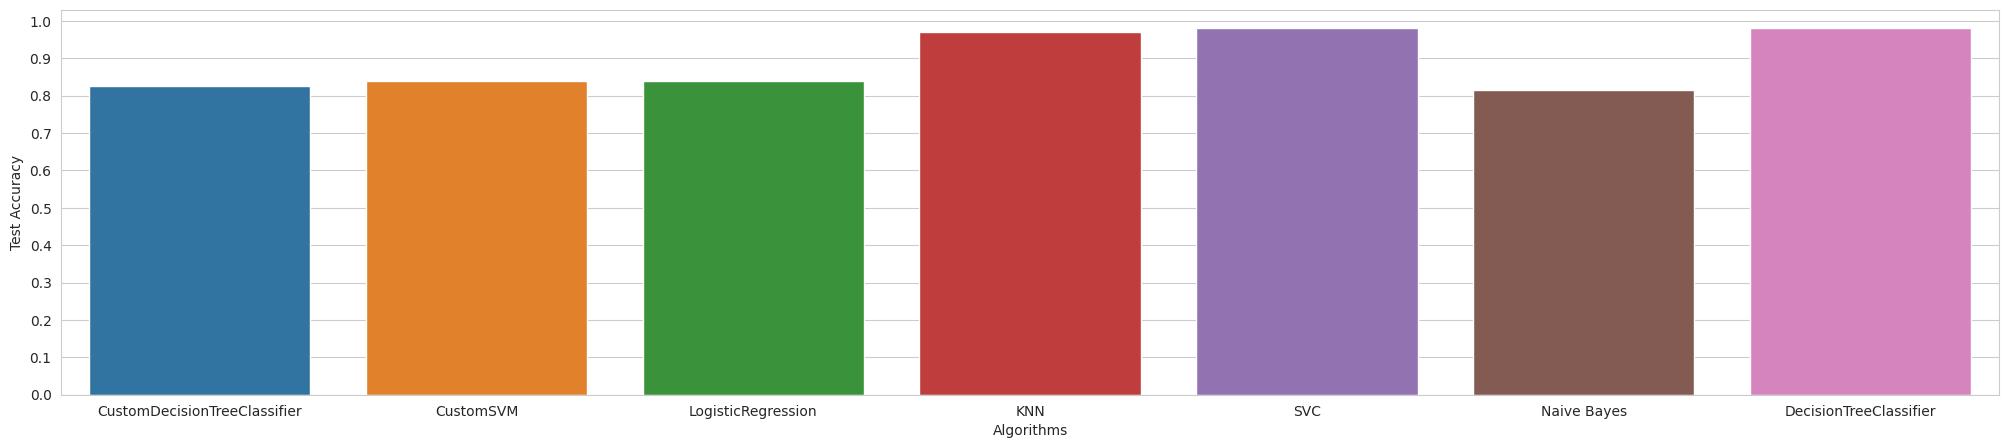

In [120]:
accuracies = {"CustomDecisionTreeClassifier" : custom_dtc_acc, "CustomSVM" : custom_svm_acc, "LogisticRegression" :lr_acc, "KNN": knn_acc, "SVC" :svm_acc, "Naive Bayes" : nn_acc, "DecisionTreeClassifier" : dt_acc}
sns.set_style("whitegrid")
plt.figure(figsize=(25, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Test Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.show()

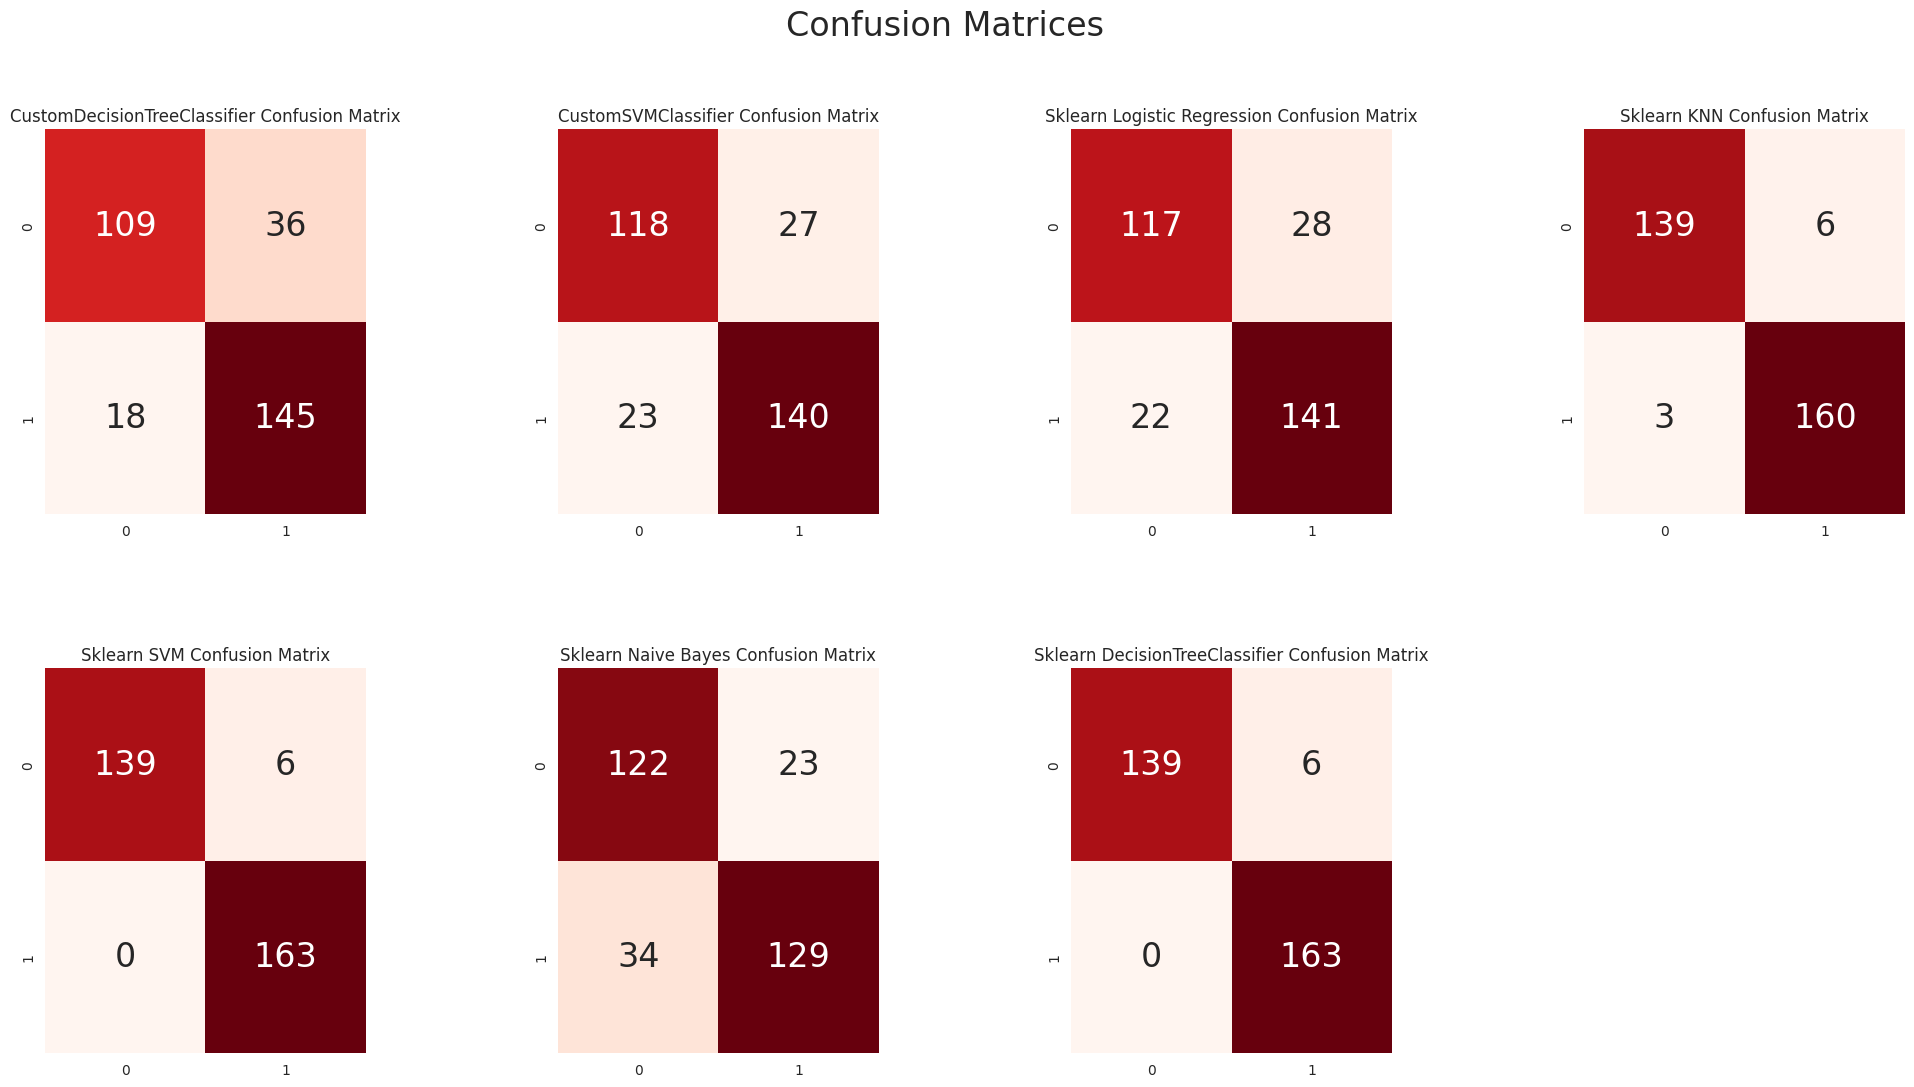

In [121]:
y_pred_custom_dtc = custom_dtc_classifier.predict(x_test_scaled)
y_pred_custom_svm = custom_svm_classifier.predict(x_test_scaled)
y_pred_lr = lr_classifier.predict(x_test_scaled)
y_pred_knn = knn_classifier.predict(x_test_scaled)
y_pred_svm = svm_classifier.predict(x_test_scaled)
y_pred_nb = naive_bayes_classifier.predict(x_test_scaled)
y_pred_dtc = dt_classifier.predict(x_test_scaled)

plt.figure(figsize=(24, 12))
plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.6, hspace= 0.4)

plt.subplot(2,4,1)
plt.title("CustomDecisionTreeClassifier Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_custom_dtc), annot=True,cmap="Reds",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,2)
plt.title("CustomSVMClassifier Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_custom_svm), annot=True, cmap="Reds", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,3)
plt.title("Sklearn Logistic Regression Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_lr),annot=True,cmap="Reds",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,4)
plt.title("Sklearn KNN Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_knn),annot=True,cmap="Reds",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,5)
plt.title("Sklearn SVM Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_svm),annot=True,cmap="Reds",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,6)
plt.title("Sklearn Naive Bayes Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_nb),annot=True,cmap="Reds",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,7)
plt.title("Sklearn DecisionTreeClassifier Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_dtc),annot=True,cmap="Reds",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

### Результаты

- Лучше всего себя показал библиотечный DecisionTreeClassifier, при этом CustomDecisionTreeClassifier на данном датасете также имеет приемлемое значение accuracy, сравнимое, например, с LogisticRegression или Naive Bayes, а также с CustomSVM.
- Из библиотечных моделей DecisionTreeClassifier, SVC и KNN находятся на одном уровне, чуть хуже на данном датасете показывают себя LogisticRegression и Naive Bayes.
- При этом все модели пересекли границу accuracy в 80%.

## Второй датасет

В качестве второго датасета возьмем наиболее популярный датасет для решения задачи классификации iris, уже встроенный в библиотеку sklearn.

In [122]:
df, iris_y = load_iris(return_X_y=True, as_frame=True)
df['species'] = load_iris()['target']
df['species'] = df['species'].map({
    0 : 'setosa',
    1 : 'versicolor',
    2 : 'virginica'
})
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Описание датасета

- Sepal Length - длина чашелистика
- Sepal Width - ширина чашелистика
- Petal Length - длина лепестка
- Petal Width - ширина лепестка
- Species - тип цветка

Будем решать задачу классификации и предсказывать целевой признак **Species** и определять тип цветка.

In [123]:
df.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64

Как видим, пропущенных значений нет.

## EDA

<Axes: xlabel='species', ylabel='count'>

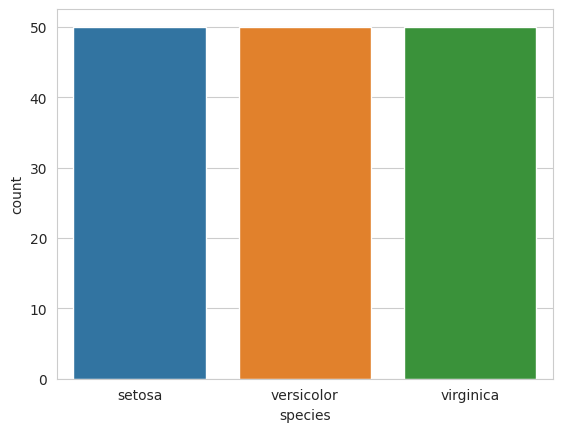

In [124]:
sns.countplot(x='species',data=df)

Видим, что у нас одинаково распределены типы цветков, по 50 цветков каждого вида.

<Axes: xlabel='species', ylabel='sepal length (cm)'>

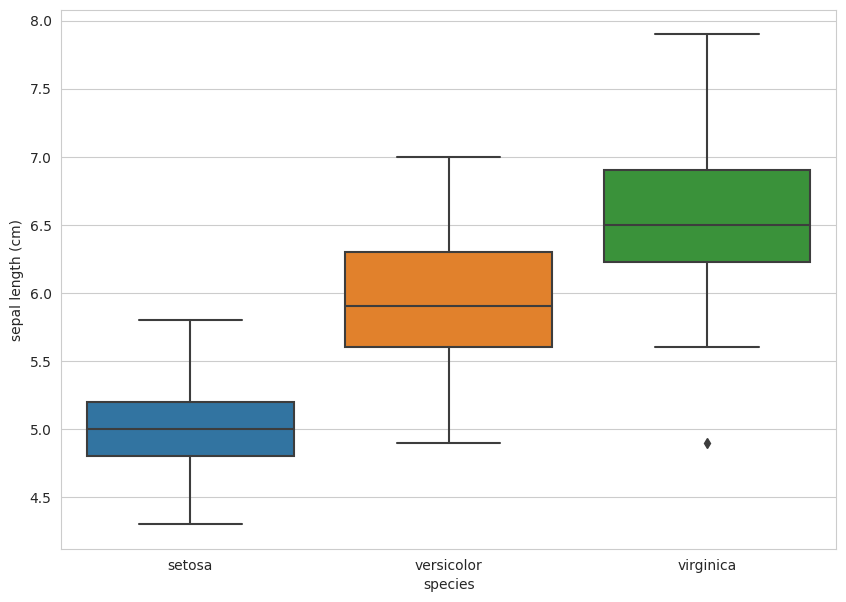

In [125]:
plt.figure(figsize=(10,7))
sns.boxplot(x='species',y='sepal length (cm)',data=df)

Видим, что тип цветка virginica имеет более длинную длину чашелистика в отличие от, например, setosa.

<Axes: xlabel='petal width (cm)', ylabel='petal length (cm)'>

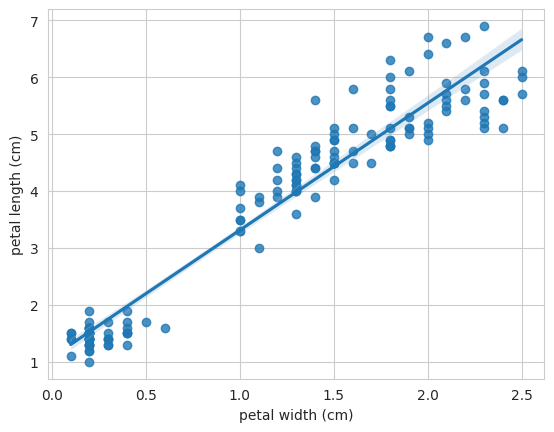

In [126]:
sns.regplot(x='petal width (cm)', y='petal length (cm)', data=df)

Можно заметить, что с увеличением ширины лепестка растет и его длина. Посмотрим на общие зависимости ширины/длины чашелистика и лепестка в зависимости от типа цветка.

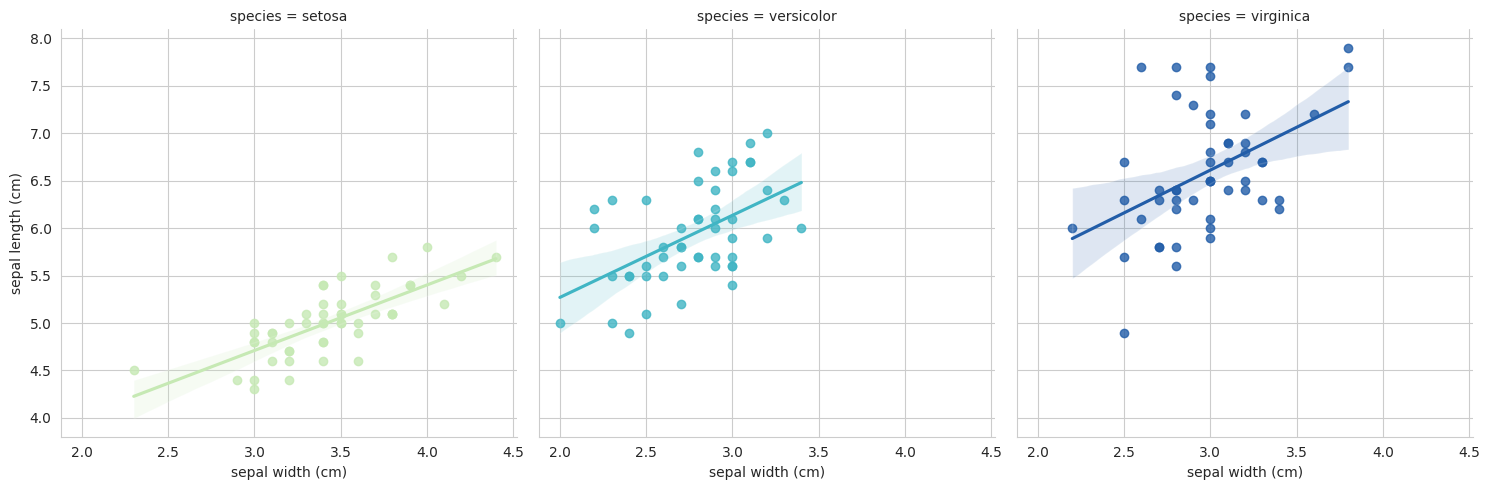

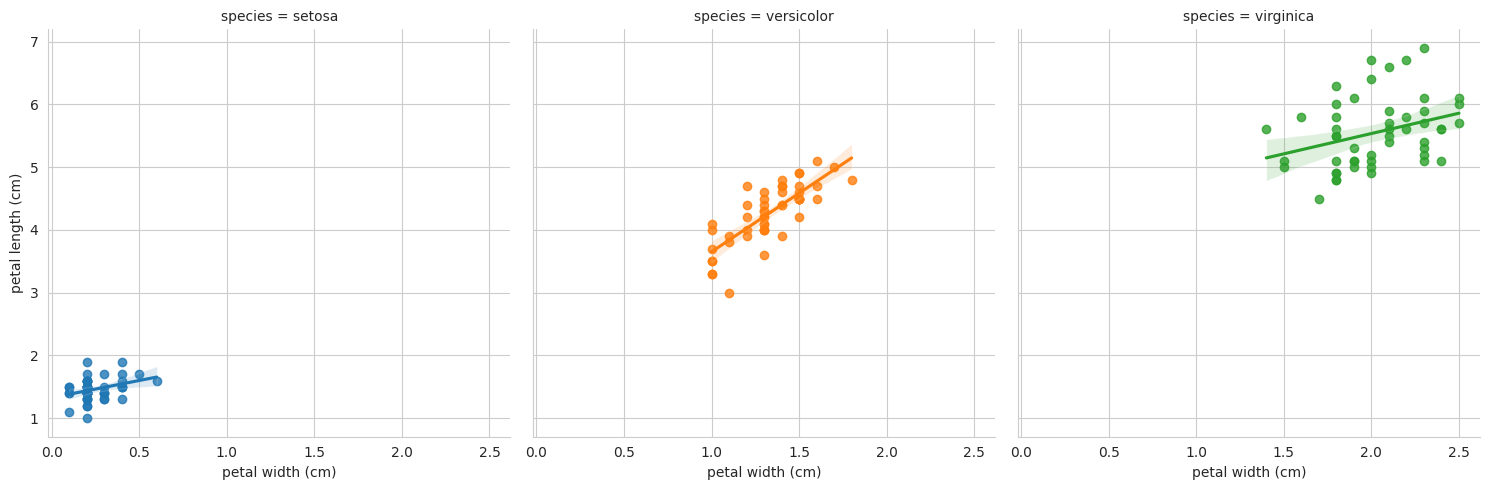

In [127]:
sns.lmplot(x = 'sepal width (cm)', y = 'sepal length (cm)', data = df, col = 'species', hue = 'species', palette = 'YlGnBu')
sns.lmplot(x = 'petal width (cm)', y = 'petal length (cm)', data = df, col = 'species', hue = 'species')

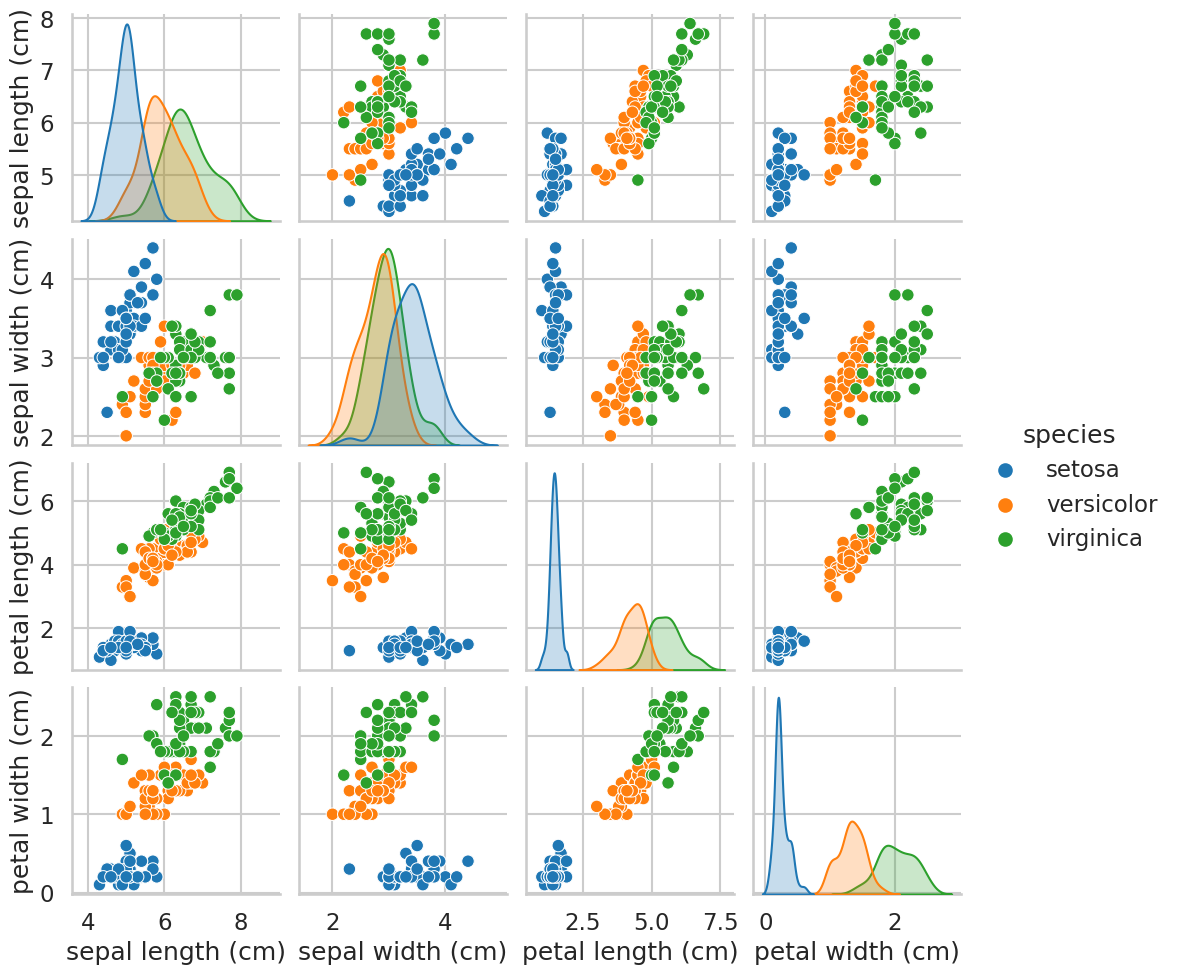

In [128]:
sns.set_context('talk')
sns.pairplot(df, hue='species')

По построенным графикам можно сделать следующие выводы:

- Тип цветка setosa достаточно сильно выделяется на фоне другие типов по ширине и длине лепестка. Так он имеет в разы меньший лепесток.
- Тип цветка setosa имеет большую ширину чашелистика и меньшую длину в сравнении с типом versicolor и verginica.
- Типы цветков versicolor и verginica во многом сходятся в размерах, однако если рассматривать граничные значения, то видно, что verginica имеет чуть большую длину чашелистика, а также чуть большую длину и ширину лепестка.

Будем учитывать это в дальнейшем, при этом можно заметить, что идентификации типа цветка setosa на основании размеров лепестка достаточно однозначна.

Преобразуем категориальный признак **species** и построим матрицу корреляции признаков друг с другом:

<Axes: >

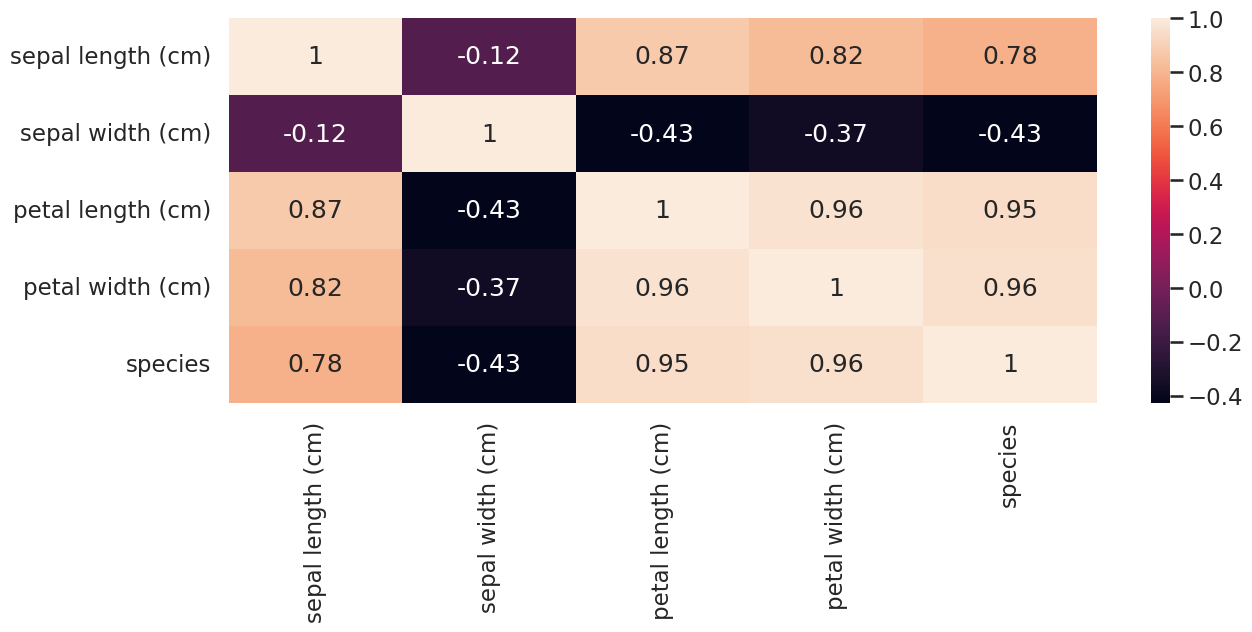

In [129]:
le = LabelEncoder()
df['species'] = le.fit_transform(df['species'])
plt.figure(figsize = (14,5))
sns.heatmap(df.corr(),annot=True)

Как можно заметить, у нас наблюдается достаточно сильная корреляция всех признаков друг с другом.

## Разбиение данных на обучающую и тестовую выборки

In [130]:
x = df.drop(['species'], axis=1)
y = df['species']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=50)

Используем также масштабирование данных:

In [131]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Recursive Feature Elimination (RFE)

Подберем наилучшее количество признаков и оставим только их.

In [133]:
rfecv = RFECV(estimator=LogisticRegression(), cv=5)
rfecv.fit(x_train_scaled, y_train)

selected_features = list(x_train.columns[rfecv.support_])

print(f"Оптимальное число признаков: {rfecv.n_features_}")
print(f'Выбранные признаки: {selected_features}')


Оптимальное число признаков: 2
Выбранные признаки: ['petal length (cm)', 'petal width (cm)']


Уберем лишние признаки:

In [134]:
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x.columns)
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x.columns)
selected_features = list(x_train_scaled_df.columns[rfecv.support_])
x_train_scaled = x_train_scaled_df[selected_features].to_numpy()
x_test_scaled = x_test_scaled_df[selected_features].to_numpy()

## Подбор гиперпараметров модели

Подберем оптимальные гиперпараметры для двух собственных алгоритмов, а также для библиотечных и будем их использовать в дальнейшем при обучении моделей.

## CustomDecisionTree

In [135]:
max_depth_grid = [2, 3, 5]
min_leaf_count_grid = [1, 2, 4]
min_split_grid = [1, 3, 5, 10]
custom_dtc_searcher = GridSearchCV(CustomDecisionTreeClassifier(),
                                   [{"max_depth": max_depth_grid, "min_leaf_count": min_leaf_count_grid,
                                     "min_split": min_split_grid}],
                                   cv=5, verbose=5)
custom_dtc_searcher.fit(x_train_scaled, y_train)

print("Best estimator: " + str(custom_dtc_searcher.best_estimator_))
print("Best params: " + str(custom_dtc_searcher.best_params_))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END max_depth=2, min_leaf_count=1, min_split=1;, score=0.714 total time=   0.2s
[CV 2/5] END max_depth=2, min_leaf_count=1, min_split=1;, score=0.714 total time=   0.2s
[CV 3/5] END max_depth=2, min_leaf_count=1, min_split=1;, score=0.667 total time=   0.3s
[CV 4/5] END max_depth=2, min_leaf_count=1, min_split=1;, score=0.667 total time=   0.2s
[CV 5/5] END max_depth=2, min_leaf_count=1, min_split=1;, score=0.667 total time=   0.2s
[CV 1/5] END max_depth=2, min_leaf_count=1, min_split=3;, score=0.714 total time=   0.3s
[CV 2/5] END max_depth=2, min_leaf_count=1, min_split=3;, score=0.714 total time=   0.3s
[CV 3/5] END max_depth=2, min_leaf_count=1, min_split=3;, score=0.667 total time=   0.2s
[CV 4/5] END max_depth=2, min_leaf_count=1, min_split=3;, score=0.667 total time=   0.2s
[CV 5/5] END max_depth=2, min_leaf_count=1, min_split=3;, score=0.667 total time=   0.3s
[CV 1/5] END max_depth=2, min_leaf_count=1, min_

## CustomSVM

In [137]:
learning_rate_grid = [0.1, 0.01, 0.001, 0.0001]
lambda_value_grid = [0.01, 0.1, 1]
iter_number_grid = [100, 1000]

custom_svm_searcher = GridSearchCV(CustomSVMClassifier(),
                                   [{"learning_rate": learning_rate_grid, "lambda_value": lambda_value_grid}],
                                   cv=5, verbose=5)
custom_svm_searcher.fit(x_train_scaled, y_train)

print("Best estimator: " + str(custom_svm_searcher.best_estimator_))
print("Best params: " + str(custom_svm_searcher.best_params_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END lambda_value=0.01, learning_rate=0.1;, score=0.667 total time=   0.0s
[CV 2/5] END lambda_value=0.01, learning_rate=0.1;, score=0.619 total time=   0.0s
[CV 3/5] END lambda_value=0.01, learning_rate=0.1;, score=0.667 total time=   0.0s
[CV 4/5] END lambda_value=0.01, learning_rate=0.1;, score=0.667 total time=   0.0s
[CV 5/5] END lambda_value=0.01, learning_rate=0.1;, score=0.667 total time=   0.0s
[CV 1/5] END lambda_value=0.01, learning_rate=0.01;, score=0.667 total time=   0.0s
[CV 2/5] END lambda_value=0.01, learning_rate=0.01;, score=0.619 total time=   0.0s
[CV 3/5] END lambda_value=0.01, learning_rate=0.01;, score=0.619 total time=   0.0s
[CV 4/5] END lambda_value=0.01, learning_rate=0.01;, score=0.667 total time=   0.0s
[CV 5/5] END lambda_value=0.01, learning_rate=0.01;, score=0.667 total time=   0.0s
[CV 1/5] END lambda_value=0.01, learning_rate=0.001;, score=0.667 total time=   0.0s
[CV 2/5] END lambda

## Sklearn Logistic Regression

In [138]:
param_grid = {'C': np.arange(1e-05, 5, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}
log_reg_searcher = GridSearchCV(LogisticRegression(), return_train_score=True,
                                param_grid=param_grid, scoring=scoring, cv=5, refit='Accuracy')
log_reg_searcher.fit(x_train_scaled, y_train)
print("Best estimator: " + str(log_reg_searcher.best_estimator_))
print("Best params: " + str(log_reg_searcher.best_params_))

Best estimator: LogisticRegression(C=0.10001)
Best params: {'C': 0.10001}


## Sklearn SVM

In [139]:
C = [0.1, 0.2, 0.5, 1, 2, 5]
kernel = ["linear", "poly", "rbf"]
gamma = [0.001, 0.01, 0.1, 1, "scale", "auto"]

svc_searcher = GridSearchCV(estimator=SVC(random_state=50), cv=5,
                            param_grid=dict(kernel=kernel, C=C, gamma=gamma))
svc_searcher.fit(x_train_scaled, y_train)
print("Best estimator: ", str(svc_searcher.best_estimator_))
print("Best params: ", str(svc_searcher.best_params_))

Best estimator:  SVC(C=0.1, gamma=1, random_state=50)
Best params:  {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


## Sklearn KNN

In [140]:
n_neighbors = np.arange(1, 11, 2)
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree']
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=7)
knn_searcher = GridSearchCV(estimator=KNeighborsClassifier(), cv=rskfold,
                            scoring=scoring, return_train_score=True,
                            param_grid=dict(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm),
                            refit='Accuracy')
knn_searcher.fit(x_train_scaled, y_train)

print("Best estimator: " + str(knn_searcher.best_estimator_))
print("Best params: " + str(knn_searcher.best_params_))

Best estimator: KNeighborsClassifier(n_neighbors=3)
Best params: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}


## Sklearn Naive Bayes

In [141]:
priors = [None, [0.5, 0.5], [0.2, 0.8], [0.7, 0.3]]
var_smoothing = np.logspace(0, -9)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=18)
nb_searcher = GridSearchCV(estimator=GaussianNB(), cv=rskfold,
                           scoring=scoring, return_train_score=True,
                           param_grid=dict(priors=priors, var_smoothing=var_smoothing), refit='Accuracy')
nb_searcher.fit(x_train_scaled, y_train)
print("Best estimator: " + str(nb_searcher.best_estimator_))
print("Best params: " + str(nb_searcher.best_params_))

Best estimator: GaussianNB(var_smoothing=0.022229964825261943)
Best params: {'priors': None, 'var_smoothing': 0.022229964825261943}


## Sklearn Decision Tree

In [142]:
criterion = ["gini", "entropy", "log_loss"]
splitter = ["best", "random"]
max_depth = [2, 3, 4, 5, 10]
min_samples_split = [2, 4, 5, 10]
min_samples_leaf = [1, 2, 4, 6]
max_features = [1, 2]

dtc_searcher = GridSearchCV(estimator=DecisionTreeClassifier(random_state=14), cv=StratifiedKFold(10),
                            param_grid=dict(criterion=criterion, splitter=splitter, max_depth=max_depth,
                                            min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                            max_features=max_features))
dtc_searcher.fit(x_train_scaled, y_train)
print("Best estimator: " + str(dtc_searcher.best_estimator_))
print("Best params: " + str(dtc_searcher.best_params_))

Best estimator: DecisionTreeClassifier(max_depth=3, max_features=2, random_state=14,
                       splitter='random')
Best params: {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}


## Обучение моделей и сравнения

Проведем обучения моделей и сравним их, используя для каждой модели подобранные гиперпараметры:


## CustomDecisionTree

In [143]:
custom_dtc_classifier = CustomDecisionTreeClassifier(custom_dtc_searcher.best_params_['max_depth'],
                                                     custom_dtc_searcher.best_params_['min_leaf_count'],
                                                     custom_dtc_searcher.best_params_['min_split'])
custom_dtc_classifier.fit(x_train_scaled, y_train)
y_test_prediction = custom_dtc_classifier.predict(x_test_scaled)
custom_dtc_acc = accuracy_score(y_test, y_test_prediction)

print("Test Accuracy of CustomDecisionTreeClassifier: {:.4f}".format(custom_dtc_acc))

Test Accuracy of CustomDecisionTreeClassifier: 0.9778


## CustomSVM

In [144]:
custom_svm_classifier = CustomSVMClassifier(learning_rate=custom_svm_searcher.best_params_["learning_rate"], lambda_value=custom_svm_searcher.best_params_["lambda_value"])
custom_svm_classifier.fit(x_train_scaled, y_train)
y_test_prediction = custom_svm_classifier.predict(x_test_scaled)
custom_svm_acc = accuracy_score(y_test, y_test_prediction)

print("Test Accuracy of CustomSVMClassifier: {:.4f}".format(custom_svm_acc))

Test Accuracy of CustomSVMClassifier: 0.6889


## Sklearn Logistic Regression

In [145]:
lr_classifier = LogisticRegression(C=log_reg_searcher.best_params_["C"])
lr_classifier.fit(x_train_scaled, y_train)
lr_acc = lr_classifier.score(x_test_scaled, y_test)

print("Test Accuracy of Sklearn LogisticRegression {:.4f}".format(lr_acc))

Test Accuracy of Sklearn LogisticRegression 0.9333


## Sklearn SVM

In [146]:
svm_classifier = SVC(C=svc_searcher.best_params_["C"], kernel=svc_searcher.best_params_["kernel"],
                     gamma=svc_searcher.best_params_["gamma"], random_state=50)
svm_classifier.fit(x_train_scaled, y_train)
svm_acc = svm_classifier.score(x_test_scaled, y_test)

print("Test Accuracy of Sklearn SVC {:.4f}".format(svm_acc))

Test Accuracy of Sklearn SVC 0.9556


## Sklearn KNN

In [147]:
knn_classifier = KNeighborsClassifier(n_neighbors=knn_searcher.best_params_["n_neighbors"],
                                      algorithm=knn_searcher.best_params_["algorithm"],
                                      weights=knn_searcher.best_params_["weights"])
knn_classifier.fit(x_train_scaled, y_train)
knn_acc = knn_classifier.score(x_test_scaled, y_test)

print("Test Accuracy of Sklearn KNN {:.4f}".format(knn_acc))

Test Accuracy of Sklearn KNN 0.9556


## Sklearn Naive Bayes

In [148]:
naive_bayes_classifier = GaussianNB(priors=nb_searcher.best_params_["priors"],
                                    var_smoothing=nb_searcher.best_params_["var_smoothing"])
naive_bayes_classifier.fit(x_train_scaled, y_train)
nn_acc = naive_bayes_classifier.score(x_test_scaled, y_test)

print("Test Accuracy of Sklearn Naive Bayes {:.4f}".format(nn_acc))

Test Accuracy of Sklearn Naive Bayes 0.9556


## Sklearn Decision Tree

In [150]:
dt_classifier = DecisionTreeClassifier(criterion=dtc_searcher.best_params_["criterion"],
                                       splitter=dtc_searcher.best_params_["splitter"],
                                       max_depth=dtc_searcher.best_params_["max_depth"],
                                       min_samples_split=dtc_searcher.best_params_["min_samples_split"],
                                       min_samples_leaf=dtc_searcher.best_params_["min_samples_leaf"],
                                       max_features=dtc_searcher.best_params_["max_features"])
dt_classifier.fit(x_train_scaled, y_train)
dt_acc = dt_classifier.score(x_test_scaled, y_test)

print("Test Accuracy of Sklearn DecisionTreeClassifier {:.4f}".format(dt_acc))

Test Accuracy of Sklearn DecisionTreeClassifier 0.9778


### Сравнения

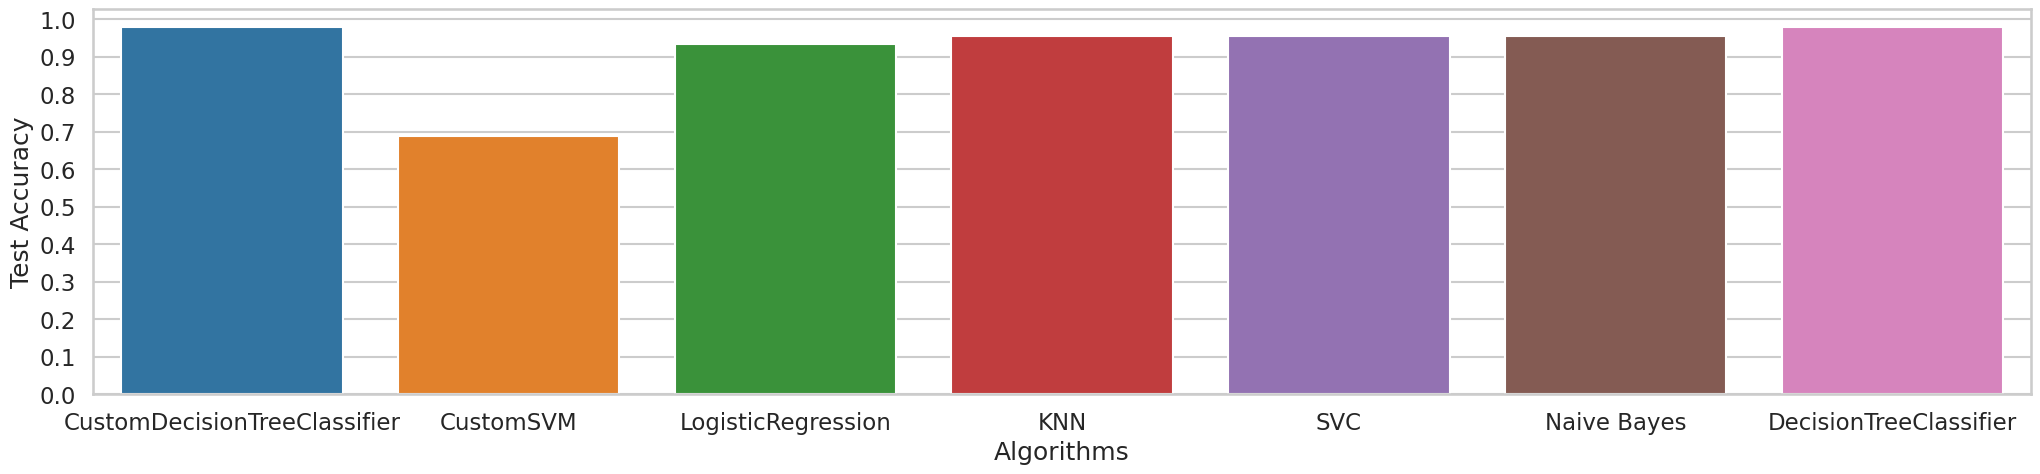

In [151]:
accuracies = {"CustomDecisionTreeClassifier" : custom_dtc_acc, "CustomSVM" : custom_svm_acc, "LogisticRegression" :lr_acc, "KNN": knn_acc, "SVC" :svm_acc, "Naive Bayes" : nn_acc, "DecisionTreeClassifier" : dt_acc}
sns.set_style("whitegrid")
plt.figure(figsize=(25, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Test Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.show()

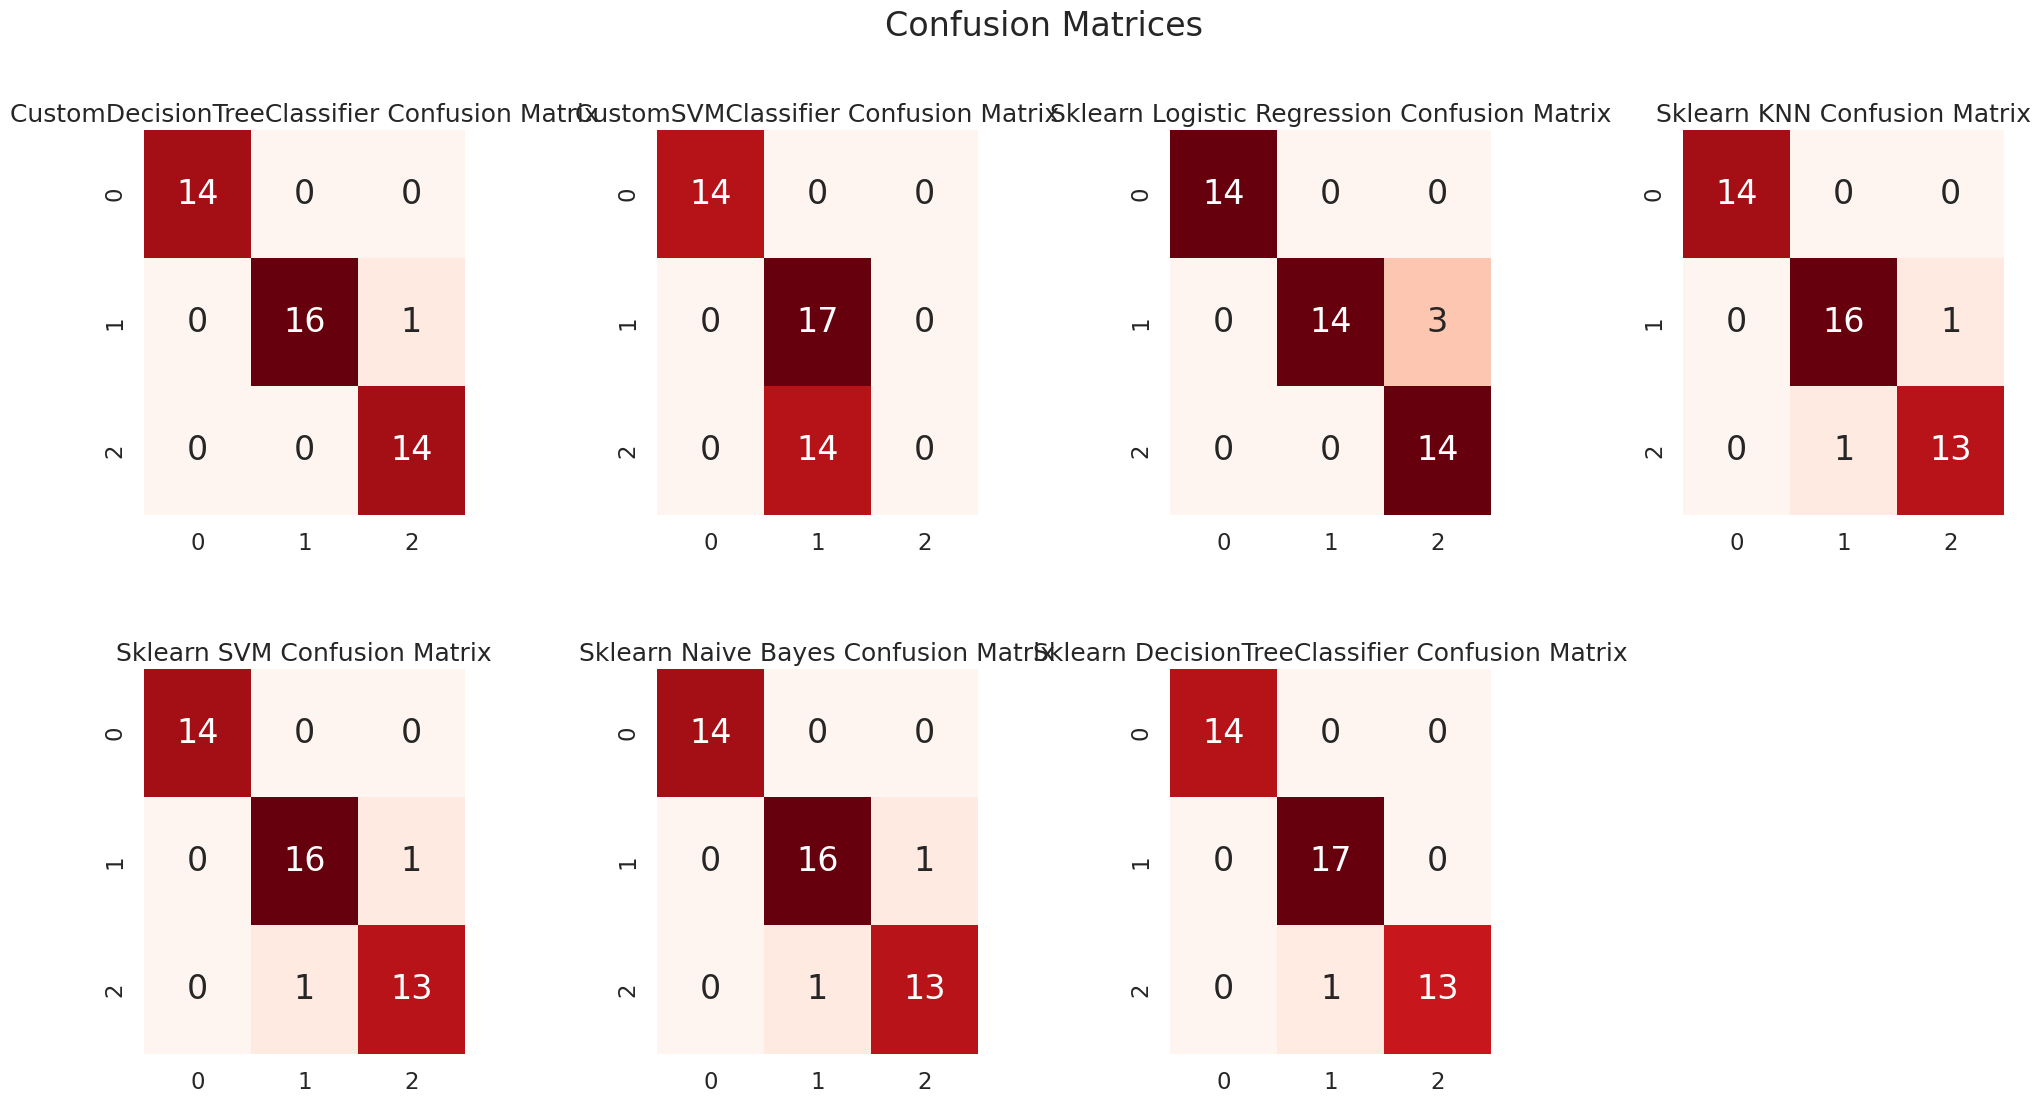

In [152]:
y_pred_custom_dtc = custom_dtc_classifier.predict(x_test_scaled)
y_pred_custom_svm = custom_svm_classifier.predict(x_test_scaled)
y_pred_lr = lr_classifier.predict(x_test_scaled)
y_pred_knn = knn_classifier.predict(x_test_scaled)
y_pred_svm = svm_classifier.predict(x_test_scaled)
y_pred_nb = naive_bayes_classifier.predict(x_test_scaled)
y_pred_dtc = dt_classifier.predict(x_test_scaled)

plt.figure(figsize=(24, 12))
plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.6, hspace= 0.4)

plt.subplot(2,4,1)
plt.title("CustomDecisionTreeClassifier Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_custom_dtc), annot=True,cmap="Reds",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,2)
plt.title("CustomSVMClassifier Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_custom_svm), annot=True, cmap="Reds", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,3)
plt.title("Sklearn Logistic Regression Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_lr),annot=True,cmap="Reds",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,4)
plt.title("Sklearn KNN Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_knn),annot=True,cmap="Reds",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,5)
plt.title("Sklearn SVM Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_svm),annot=True,cmap="Reds",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,6)
plt.title("Sklearn Naive Bayes Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_nb),annot=True,cmap="Reds",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,4,7)
plt.title("Sklearn DecisionTreeClassifier Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_dtc),annot=True,cmap="Reds",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

Выводы:

- Лучше всего себя показали CustomDecisionTreeClassifier и Sklearn DecisionTreeClassifier.
- При этом CustomDecisionTreeClassifier, LogisticRegression, SVC, KNN, Naive Bayes и DecisionTreeClassifier имеют приближенный к 100% accuracy.
- Хуже себя показывают CustomSVM, что может быть связано с небольшим количеством выбранных признаков.